In [1]:
config='NATL60'
case='CJM165'
freq='1d'
region='EU'

year='2013'


In [2]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.scale(280)
cluster

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [3]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.1:42394 Dashboard: http://172.30.100.1:35397/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           8990751     hsw24 make_pro albert7a  R       0:00      1 n2277
           8990752     hsw24 make_pro albert7a  R       0:00      1 n2419
           8990753     hsw24 make_pro albert7a  R       0:00      1 n2635
           8990754     hsw24 make_pro albert7a  R       0:00      1 n2943
           8990755     hsw24 make_pro albert7a  R       0:00      1 n3087
           8990756     hsw24 make_pro albert7a  R       0:00      1 n3099
           8990757     hsw24 make_pro albert7a  R       0:00      1 n2777
           8990758     hsw24 make_pro albert7a  R       0:00      1 n2778
           8990759     hsw24 make_pro albert7a  R       0:00      1 n2993
           8990760     hsw24 make_pro albert7a  R       0:00      1 n2996


In [5]:
import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

110


In [6]:
## path for mdules

import sys
sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/xscale")
import xscale

sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/diags-CMEMS-on-occigen/common-lib/")
import GriddedData

import os
import sys
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob
import time

%matplotlib inline


In [7]:
if region == 'EU':
    imin=3858
    imax=5076
    jmin=424
    jmax=3286
    
#cdffindij -w -80.418  -40.000   26.991   47.986 -c /store/molines/NATL60/NATL60-I/NATL60_coordinates_v4.nc
if region == 'GS':
    imin=63
    imax=2507
    jmin=29
    jmax=1611

In [8]:
## Dataset

gridfile='/store/molines/NATL60/NATL60-I/NATL60_coordinates_v4.nc'
maskfile='/store/molines/NATL60/NATL60-I/NATL60_v4.1_cdf_byte_mask.nc'
meshhgrfile='/store/molines/NATL60/NATL60-I/NATL60_v4.1_cdf_mesh_hgr.nc'
meshzgrfile='/store/molines/NATL60/NATL60-I/NATL60_v4.1_cdf_mesh_zgr.nc'

In [9]:
grid=xr.open_dataset(gridfile)
navlat= grid['nav_lat'][jmin:jmax,imin:imax]
navlon= grid['nav_lon'][jmin:jmax,imin:imax]

In [10]:
def compute_TKE(u2mean,v2mean):
    ua=0.5*(u2mean+u2mean.shift(x=1))
    va=0.5*(v2mean+v2mean.shift(y=1))
    uat=ua.rename({'depthu':'deptht'})
    vat=va.rename({'depthv':'deptht'})
    tke=0.5*(uat+vat)
    return tke


In [11]:
def compute_EKE(u2,v2,u2mean,v2mean):
    ua=0.5*((-1*u2+u2mean)+(-1*u2.shift(x=1)+u2mean.shift(x=1)))
    va=0.5*((-1*v2+v2mean)+(-1*v2.shift(y=1)+v2mean.shift(y=1)))
    uat=ua.rename({'depthu':'deptht'})
    vat=va.rename({'depthv':'deptht'})
    eke=0.5*(uat+vat)
    return eke


In [12]:
def filt(w):
    win_box2D = w.window
    win_box2D.set(window='hanning', cutoff=90, dim=['x', 'y'], n=[90, 90])
    bw = win_box2D.boundary_weights(drop_dims=[])
    w_LS = win_box2D.convolve(weights=bw)
    w_SS=w-w_LS
    return w_SS


In [13]:
month_name={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
def plot_ratio_eke_tke_monthly(var,loncrs,latcrs,lon,lat,hpvarm,m,mm,config,case):
    if region == 'EU':
        fig, ax = plt.subplots(1,1,figsize=(10,15))
    if region == 'GS':
        fig, ax = plt.subplots(1,1,figsize=(15,10))
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
    ax.autoscale(tight=True)
    cont=np.isnan(hpvarm)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 25, 'color': 'gray'}
    gl.ylabel_style = {'size': 25, 'color': 'gray'}
    
    ax.tick_params('both',labelsize=25)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),cmap='rainbow',vmin=0,vmax=2,alpha=1)
    ax.contour(lon,lat,cont,alpha=0.5,linewidth=0.000001,antialiased=True,colors='black')
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label('Ratio of eke over tke in '+str(month_name[m])+' for '+config+'-'+case,fontsize=15)
    plt.savefig('Plots/'+config+region+'-'+case+'_y'+year+'m'+mm+'_ratio_eke_tke.png')
  

In [14]:
def plot_ratio(month,year):
    mm = "{:02d}".format(month)
    datadir='/store/molines/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
    filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m'+str(mm)+'d??.'+str(freq)+'_gridU.nc'))
    filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m'+str(mm)+'d??.'+str(freq)+'_gridV.nc'))
    dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':10,'depthu':1})
    dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':10,'depthv':1})
    u=dsU.vozocrtx
    v=dsV.vomecrty
    u_SS=filt(u)
    u_LS=u-u_SS
    v_SS=filt(v)
    v_LS=v-v_SS
    u2_SS=u_SS[:,0,jmin:jmax,imin:imax]*u_SS[:,0,jmin:jmax,imin:imax]
    v2_SS=v_SS[:,0,jmin:jmax,imin:imax]*v_SS[:,0,jmin:jmax,imin:imax]
    tke_SS=compute_TKE(u2_SS,v2_SS)
    u2_LS=u_LS[:,0,jmin:jmax,imin:imax]*u_LS[:,0,jmin:jmax,imin:imax]
    v2_LS=v_LS[:,0,jmin:jmax,imin:imax]*v_LS[:,0,jmin:jmax,imin:imax]
    tke_LS=compute_TKE(u2_LS,v2_LS)
    ratio=tke_SS.mean(dim='time_counter')/tke_LS.mean(dim='time_counter')
    hpcurl=ratio
    hpcurl2 = hpcurl ** 2
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    hpcurl2mc = crs.return_ravel(np.asarray(hpcurl2))
    hpcurl2mcm = np.mean(hpcurl2mc,axis=-3)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)
    plot_ratio_eke_tke_monthly(hpcurl2mcm,loncrsm,latcrsm,navlon,navlat,ratio,month,mm,config,case)


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/i

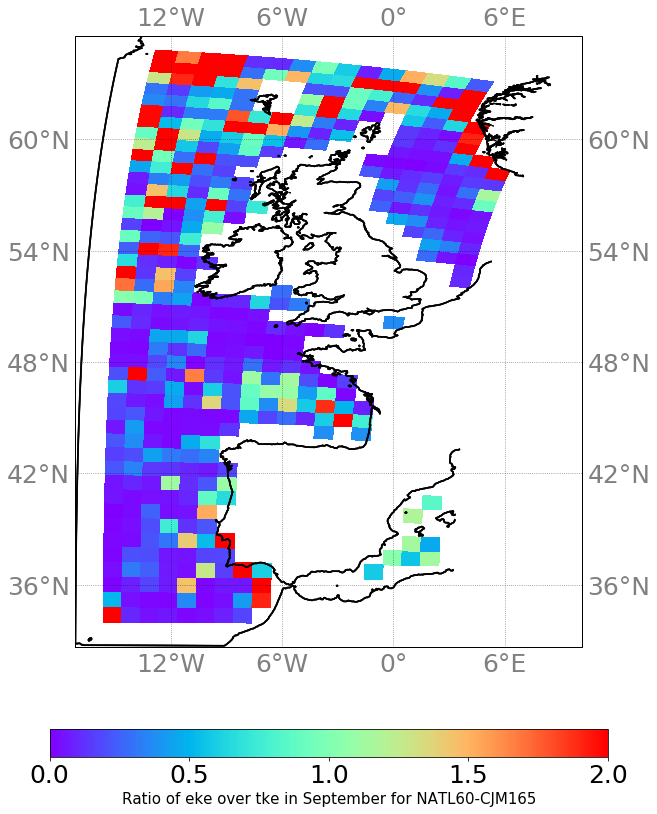

In [15]:
for month in [9]:
    plot_ratio(month,year)

In [16]:
#test if workers still active
print(len(client.scheduler_info()["workers"]))

280
